In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('loan_approval_dataset_updated.csv', encoding='ISO-8859-1')

# Preprocess data (handle missing values, categorical encoding, scaling)
# Remove any leading or trailing spaces in column names
data.columns = data.columns.str.strip()

# Use LabelEncoder for 'City', 'education', and 'self_employed' instead of one-hot encoding
label_encoder = LabelEncoder()

# Apply LabelEncoder to the columns
data['City'] = label_encoder.fit_transform(data['City'])
data['education'] = label_encoder.fit_transform(data['education'])
data['self_employed'] = label_encoder.fit_transform(data['self_employed'])

# Ensure that 'loan_status' exists and has the correct name
print(data.columns)

# Check the column types to identify non-numeric columns
print(data.dtypes)

# Check for null values in each column
null_counts = data.isnull().sum()

# Display the count of null values per column
print("Null values in each column:")
print(null_counts)

# Fill null values with 0
data = data.fillna(0)

# Preview the processed data
data.head(10)


Index(['loan_id', 'no_of_dependents', 'City', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')
loan_id                       int64
no_of_dependents              int64
City                          int32
education                     int32
self_employed                 int32
income_annum                  int64
loan_amount                   int64
loan_term                     int64
cibil_score                 float64
residential_assets_value    float64
commercial_assets_value       int64
luxury_assets_value           int64
bank_asset_value              int64
loan_status                  object
dtype: object
Null values in each column:
loan_id                       0
no_of_dependents              0
City                          0
education                     0
self_employed                 0
in

,loan_id,no_of_dependents,City,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,0,0,0,9600000,29900000,12,778.0,2400000.0,17600000,22700000,8000000,Approved
1,2,0,0,1,1,4100000,12200000,8,417.0,2700000.0,2200000,8800000,3300000,Rejected
2,3,3,0,0,0,9100000,29700000,20,0.0,7100000.0,4500000,33300000,12800000,Rejected
3,4,3,0,0,0,8200000,30700000,8,0.0,18200000.0,3300000,23300000,7900000,Rejected
4,5,5,0,1,1,9800000,24200000,20,0.0,12400000.0,8200000,29400000,5000000,Rejected
5,6,0,0,0,1,4800000,13500000,10,0.0,6800000.0,8300000,13700000,5100000,Rejected
6,7,5,0,0,0,8700000,33000000,4,0.0,22500000.0,14800000,29200000,4300000,Approved
7,8,2,0,0,1,5700000,15000000,20,0.0,13200000.0,5700000,11800000,6000000,Rejected
8,9,0,0,0,1,800000,2200000,20,0.0,1300000.0,800000,2800000,600000,Approved
9,10,5,0,1,0,1100000,4300000,10,0.0,3200000.0,1400000,3300000,1600000,Rejected


In [17]:
##Feature engineering
# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['no_of_dependents', 'income_annum', 'loan_amount', 
                  'loan_term', 'cibil_score', 'residential_assets_value', 
                  'commercial_assets_value', 'luxury_assets_value', 
                  'bank_asset_value']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Create interaction features
data['income_loan_ratio'] = data['income_annum'] / data['loan_amount']




In [18]:
data

,loan_id,no_of_dependents,City,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,income_loan_ratio
0,1,-0.294102,0,0,0,1.617979,1.633052,0.192617,0.982972,-0.745183,2.877289,0.832028,0.930304,Approved,0.990770
1,2,-1.473548,0,1,1,-0.341750,-0.324414,-0.508091,-0.538043,-0.699320,-0.631921,-0.694993,-0.515936,Rejected,1.053436
2,3,0.295621,0,0,0,1.439822,1.610933,1.594031,-2.295004,-0.026661,-0.107818,1.996520,2.407316,Rejected,0.893781
3,4,0.295621,0,0,0,1.119139,1.721525,-0.508091,-2.295004,1.670274,-0.381263,0.897943,0.899533,Rejected,0.650086
4,5,1.475067,0,1,1,1.689242,1.002681,1.594031,-2.295004,0.783587,0.735304,1.568075,0.007172,Rejected,1.684725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,4265,1.475067,4,0,1,-1.446324,-1.419268,0.192617,-0.959376,-0.684032,-1.019301,-1.299210,-1.285213,Rejected,1.019063
4265,4266,-1.473548,4,1,1,-0.626801,-0.423946,1.594031,0.060251,-0.470005,-0.472412,-0.453306,-0.946732,Approved,1.478492
4266,4267,-0.294102,4,1,0,0.513405,0.969504,1.243677,-0.369509,-0.928636,1.692361,0.326683,0.714907,Rejected,0.529554
4267,4268,-0.883825,4,1,0,-0.341750,-0.258059,-0.508091,0.991398,0.141503,-0.973727,-0.112748,0.253341,Approved,1.324306


Class counts for 'loan_status':
 Approved    2656
 Rejected    1613
Name: loan_status, dtype: int64


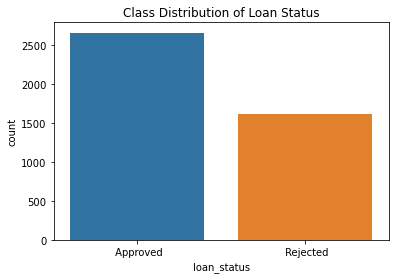

In [19]:
##Prevent overfitting
# Check class distribution for the target variable 'loan_status'
class_counts = data['loan_status'].value_counts()

# Print class counts
print("Class counts for 'loan_status':")
print(class_counts)

# Visualize class distribution using a bar plot
sns.countplot(x='loan_status', data=data)
plt.title('Class Distribution of Loan Status')
plt.show()

### Slight Imbalance: The imbalance is moderate but not severe. 
A 62:38 ratio means the model may still tend to predict "Approved" more frequently 
if no measures are taken.

Imbalance Effects: If the goal is to ensure good performance for both classes (especially if predicting rejections is important), we may want to consider addressing this. Otherwise, the model might favor predicting the majority class, which can lead to lower accuracy for the minority class (Rejected).

##To prevent overfitting imbalance class problems should be solved.

#Use Class Weights: Many algorithms, such as Logistic Regression, Decision Trees, and SVM, have options to assign higher weights to the minority class. This adjusts the loss function to penalize misclassifications of the minority class more, balancing the model's attention to both classes.

#Oversampling (e.g., SMOTE): We can apply SMOTE to create synthetic samples for the minority class and balance the dataset. This is especially useful if you prefer not to modify the algorithm itself but rather the data.

#Threshold Adjustment: After training the model, We can adjust the decision threshold to favor a balance between precision and recall for both classes.

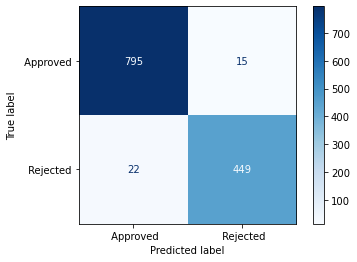

              precision    recall  f1-score   support

    Approved       0.97      0.98      0.98       810
    Rejected       0.97      0.95      0.96       471

    accuracy                           0.97      1281
   macro avg       0.97      0.97      0.97      1281
weighted avg       0.97      0.97      0.97      1281



['scaler.pkl']

In [20]:


# Feature engineering

# Train-test split
X = data.drop('loan_status', axis=1)
y = data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model training
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Model evaluation
y_pred = clf.predict(X_test)
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Display classification report
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(clf, 'loan_prediction_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

In [23]:
data.head(10)


,loan_id,no_of_dependents,City,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,income_loan_ratio
0,1,-0.294102,0,0,0,1.617979,1.633052,0.192617,0.982972,-0.745183,2.877289,0.832028,0.930304,Approved,0.990770
1,2,-1.473548,0,1,1,-0.341750,-0.324414,-0.508091,-0.538043,-0.699320,-0.631921,-0.694993,-0.515936,Rejected,1.053436
2,3,0.295621,0,0,0,1.439822,1.610933,1.594031,-2.295004,-0.026661,-0.107818,1.996520,2.407316,Rejected,0.893781
3,4,0.295621,0,0,0,1.119139,1.721525,-0.508091,-2.295004,1.670274,-0.381263,0.897943,0.899533,Rejected,0.650086
4,5,1.475067,0,1,1,1.689242,1.002681,1.594031,-2.295004,0.783587,0.735304,1.568075,0.007172,Rejected,1.684725
5,6,-1.473548,0,0,1,-0.092330,-0.180645,-0.157737,-2.295004,-0.072524,0.758091,-0.156691,0.037943,Rejected,0.511109
6,7,1.475067,0,0,0,1.297296,1.975885,-1.208798,-2.295004,2.327645,2.239251,1.546103,-0.208226,Approved,0.656565
7,8,-0.294102,0,0,1,0.228353,-0.014758,1.594031,-2.295004,0.905888,0.165627,-0.365420,0.314883,Rejected,-15.472708
8,9,-1.473548,0,0,1,-1.517587,-1.430327,1.594031,-2.295004,-0.913348,-0.950940,-1.354139,-1.346756,Approved,1.061007
9,10,1.475067,0,1,0,-1.410692,-1.198085,-0.157737,-2.295004,-0.622882,-0.814218,-1.299210,-1.039045,Rejected,1.177456
